## Blue Book for Bulldozers

**Details**: [Source](https://www.kaggle.com/c/bluebook-for-bulldozers/data)

In [1]:
import csv
import numpy as np
import pandas as pd

from rfpimp import * 
from pandas.api.types import is_categorical_dtype
from sklearn.ensemble import RandomForestRegressor
from pandas.api.types import is_string_dtype, is_object_dtype

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
color_palette = {
    'crimson': '#a50026', 
    'red': '#d73027',
    'redorange': '#f46d43', 
    'orange': '#fdae61',
    'yellow': '#fee090', 
    'sky': '#e0f3f8',
    'babyblue': '#abd9e9', 
    'lightblue': '#74add1',
    'blue': '#4575b4', 
    'purple': '#313695'
}


def inspect(data_frame):
    """
    Inspects a data frame. It gives a new data frame with column names, sample vector, 
    data types of columns, and percentage of missing values per column.

    Attributes:
    -----------
    data_frame: A data frame to inspect.

    Return:
    -------
    A new data frame with column names, sample vector, data types of columns, 
    and percentage of missing values per column.

    Example:
    --------
    >>> df = pd.DataFrame({'Column 1': [1, 2, 3, 4], 'Column 2': ['A', 'B', 'C', 'D']})
    >>> inspect(df)
    >>>
                sample	    data type	percent missing
    Column 1	1	        int64	    0.0
    Column 2	A	        object	    0.0
    """
    with pd.option_context("display.max_colwidth", 20):
        info = pd.DataFrame()
        info['sample'] = data_frame.iloc[0]
        info['data type'] = data_frame.dtypes
        info['percent missing'] = data_frame.isnull().sum()*100/len(data_frame)

        return info.sort_values('data type')


def train_rf(X, y, n_estimators=50):
    """
    Trains random forest regressor. 

    Attributes:
    -----------
    X: The training data set.
    y: The target variable.
    n_estimators: The number of trees in a random forest.

    Return:
    -------
    Random forest model and OOB score.
    """
    # train RandomForest model
    rf = RandomForestRegressor(n_estimators=n_estimators, n_jobs=-1, oob_score=True)
    rf.fit(X, y)

    # calculate OOB score and model parameters (trees and heights)
    oob = rf.oob_score_
    total_nodes = rfnnodes(rf)
    median_height = np.median(rfmaxdepths(rf))

    print(f"OOB R^2 {oob:.5f} using {total_nodes:,d} tree nodes with {median_height} median tree height")
    return rf, oob


def df_normalize_strings(df):
    """
    Normalizes string columns in the data frame.

    Attributes:
    -----------
    data_frame: A data frame.

    Return:
    -------
    Normalized string values.
    """
    for col in df.columns:
        if is_string_dtype(df[col]) or is_object_dtype(df[col]):
            df[col] = df[col].str.lower()
            df[col] = df[col].fillna(np.nan) # make None -> np.nan
            df[col] = df[col].replace('none or unspecified', np.nan)
            df[col] = df[col].replace('none', np.nan)
            df[col] = df[col].replace('#name?', np.nan)
            df[col] = df[col].replace('', np.nan)

def extract_sizes(df, colname):
    """
    Function to convert a column of strings to a numeric column by extracting 
    any integer or floating-point numbers on the front of the string.
    """
    df[colname] = df[colname].str.extract(r'([0-9.]*)', expand=True)
    df[colname] = df[colname].replace('', np.nan)
    df[colname] = pd.to_numeric(df[colname])


def df_string_to_cat(df):
    """
    Coverts all string columns to categorical variables.
    """
    for col in df.columns:
        if is_string_dtype(df[col]):
            df[col] = df[col].astype('category').cat.as_ordered()

def df_cat_to_catcode(df):
    """
    Convert categorical variables to numerical with their respective codes.
    """
    for col in df.columns:
        if is_categorical_dtype(df[col]):
            df[col] = df[col].cat.codes + 1


def fix_missing_num(df, colname):
    """
    Fixes missing numerical values by replacing them with median value of a column
    and creates a new column of values where median was imputed.
    """
    df[colname + '_na'] = pd.isnull(df[colname])
    df[colname].fillna(df[colname].median(), inplace=True)


def init_processing():
    """
    This function does initial processing of data files. In order to work you need to have in data
    directory next files:
        
        - bulldozers.csv
        - Valid.csv
        - ValidSolution.csv

    NOTE: This function needs to be executed once at the very start of data processing.
    """
    dtypes = {col:str for col in ['fiModelSeries', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow']}

    df = pd.read_csv('../data/bulldozers.csv', dtype=dtypes, parse_dates=['saledate'])
    df = df.sort_values('saledate')
    df = df.reset_index(drop=True)

    df.to_feather("bulldozer-train-all.feather")
    print("Created bulldozer-train-all.feather")

    # Split out validation set and make training/validation sets
    n_valid = 12000  # same as Kaggle's test set size
    n_train = len(df)-n_valid
    df_train = df[:n_train].reset_index(drop=True)
    df_valid = df[n_train:].reset_index(drop=True)

    df_train.to_feather("bulldozer-train.feather")
    print("Created bulldozer-train.feather")
    df_valid.to_feather("bulldozer-valid.feather")
    print("Created bulldozer-valid.feather")

    # Read Kaggle validation / solution and make it our test set
    df_test = pd.read_csv("../data/Valid.csv", dtype=dtypes, parse_dates=['saledate'])
    df_test = df_test.sort_values('saledate')
    df_test_soln = pd.read_csv("../data/ValidSolution.csv")
    df_test_soln['SalePrice'] = df_test_soln['SalePrice'].astype(int)
    del df_test_soln['Usage']
    df_merged = df_test.merge(df_test_soln, on='SalesID', how='left') # merge in solution
    df_merged.to_feather("bulldozer-test.feather")
    print("Created bulldozer-test.feather")

### 1. Loading the bulldozer data

When inspecting a dataset for the first time, look for this key summary information: the column names, column datatypes, sample data elements, and how much data is missing.

In [3]:
# read training data set from feather format
df_raw = pd.read_feather("../data/bulldozer-train.feather")
# it's a good idea to keep the original data around in df_raw 
# so that we can undo any data transformations that end up being unhelpful
df = df_raw.copy()

# finally inspect a data set
inspect(df).head(15)

,sample,data type,percent missing
SalesID,1646770,int64,0.000000
SalePrice,9500,int64,0.000000
MachineID,1126363,int64,0.000000
ModelID,8434,int64,0.000000
datasource,132,int64,0.000000
YearMade,1974,int64,0.000000
auctioneerID,18,float64,5.174687
MachineHoursCurrentMeter,NaN,float64,64.717764
saledate,1989-01-17 00:00:00,datetime64[ns],0.000000
Coupler,None,object,46.826855


We can learn a lot just from this quick inspection. There are three kinds of data: numeric, date time, and strings (object). Some columns are complete, but others have missing data, including column _Tip\_Control_ that is 94% missing. Some values are just plain missing (represented as either the None object or "not a number" np.nan in Python), but other "missing" values are actually physically-present strings like "None or Unspecified" (_Ripper_ column).

Columns such as _SalesID_ and _ModelID_ are represented as integers (int64), but they are really nominal categorical variables. Model 8434 is not somehow greater than model 8433. There are also columns represented as strings that contain numeric values, such as _Hydraulics_ ("2 Valve"). Other columns are represented as strings but are actually purely numeric but with units such as feet or inches (_Tire\_Size_).

### 2. Baseline model

While we only have a few numeric columns out of the 52 total, and some of those values are missing, it's still a good idea to train a model early on in our process. First, it tells us how long training the model takes. If training time is significant, we should consider working with a subset of the data. Second, it gives us an initial appraisal of the strength of the relationship between numeric features and the SalePrice target variable. The OOB from this initial model is our lower bound, so if it's pretty good, we can be optimistic about the performance of our model after feature engineering. Finally, a feature importance graph derived from the model helps to focus our cleanup efforts on the most predictive columns.

In [4]:
# first, we extracted numeric features
# some of those columns have missing values ~ like auctioneerID (5%), MachineHoursCurrentMeter (65%)
numeric_features = ['SalesID', 'MachineID', 'ModelID', 'datasource', 'YearMade', 'auctioneerID', 'MachineHoursCurrentMeter']


X, y = df[numeric_features], df['SalePrice']
X = X.fillna(0) # flip missing numeric values to zeros
%time rf, oob_baseline_initial = train_rf(X, y)

OOB R^2 0.78122 using 22,505,660 tree nodes with 55.0 median tree height
CPU times: user 3min 19s, sys: 3.39 s, total: 3min 22s
Wall time: 51.2 s


That **OOB** score is not horrible and hints that there is a strong relationship to capture in this dataset.

Unfortunately, training the model takes about 25 seconds, which would seem like an eternity as we repeatedly transformed data and retrained the model. To reduce training time, we could subsample the dataframe with _df.sample(n=100_000)_, and that's how we'd do it if this were not time-sensitive data. Instead, let's grab the last 100,000 records (which are sorted by date), taking advantage of the fact that more recent data will be better at predicting the near future.

In [5]:
# take only last 100,000 records
df = df.iloc[-100_000:]

# train random forest with recent 100,000 records
X, y = df[numeric_features], df['SalePrice']
X = X.fillna(0)
%time rf, oob_baseline = train_rf(X, y)

OOB R^2 0.84525 using 5,556,080 tree nodes with 45.0 median tree height
CPU times: user 38.7 s, sys: 656 ms, total: 39.4 s
Wall time: 10.4 s


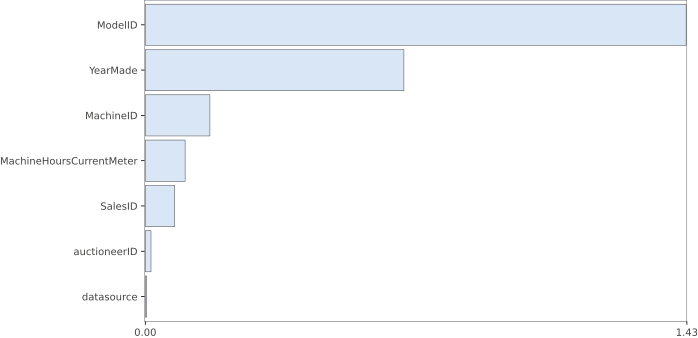

In [6]:
importances_ = importances(rf, X, y)
plot_importances(importances_, width=10, minheight=5)

The most important features are consistent with what we'd expect when evaluating a vehicle's value: what kind (model) of bulldozer it is, when it was made, how long it's been in use, etc.

### 3. Cleaning up

The easiest things to fix in the cleanup process are the small administrative details like changing column datatypes and deleting unusable columns.

* According to the data description at Kaggle, **SalesID** is a unique identifier for a particular transaction. This is clearly not predictive as a **SalesID** value will never be seen again as a feature, so we can remove it.

* We can also remove **MachineID** because it's not strongly-predictive.

* The **auctioneerID** column values look like numbers, but they are really categorical variables, specifically nominal variables that have no order.

In [7]:
# generally not predictive
del df['MachineID']
del df['SalesID']

# auctioneerID is nominal categorical variable
df['auctioneerID'] = df['auctioneerID'].astype(str)

# all of the different ways to say none are collapsed to np.nan and strings all are lowercase
df_normalize_strings(df)

# columns that have values in inches or other units
extract_sizes(df, 'Tire_Size')
extract_sizes(df, 'Undercarriage_Pad_Width')

# to examine values of a column Jeremy and Terence use
print(df['Blade_Width'].unique())
print(df['Stick_Length'].unique())
print(df['Tire_Size'].unique())
print(df['Undercarriage_Pad_Width'].unique())
print(df['Drive_System'].unique())
print(df['Backhoe_Mounting'].unique())

[nan "12'" "14'" "13'" "16'" "<12'"]
[nan '10\' 6"' '9\' 6"' '9\' 7"' '10\' 2"' '12\' 8"' '12\' 10"' '9\' 10"'
 '9\' 8"' '11\' 0"' '10\' 10"' '8\' 6"' '9\' 5"' '14\' 1"' '11\' 10"'
 '6\' 3"' '12\' 4"' '8\' 2"' '8\' 10"' '8\' 4"' '15\' 9"' '13\' 10"'
 '13\' 7"' '15\' 4"' '19\' 8"']
[ nan 26.5 20.5 17.5 23.5 14.  13.  29.5 15.5  7.  10.  23.1]
[nan 36. 24. 20. 34. 26. 30. 28. 32. 16. 31. 18. 22. 33. 14. 27. 25. 15.]
[nan 'two wheel drive' 'four wheel drive' 'no' 'all wheel drive']
[nan 'yes']


### 4. Dealing with missing data

Missing data in CSV files is often indicated as physically missing (two commas in a row like "a,,b"), but some records use physically-present string values such as `None` or `Unspecified`. Some files use special indicator numbers to represent missing numeric values, such as -1 or 0. Pandas uses Numpy's `np.nan` ("not a number") to represent values missing from data files in memory, for both numeric and string data types. The point is that the definition of missing is ambiguous and depends on the dataset. That's why we normalized strings in the previous section so that only np.nan indicates "missing".

Once the entire dataframe has a single definition of missing value, we still have to do something intelligent with these holes. Models can't train on "not a number" values. Our recipe to handle missing values looks like this: 

* For numeric columns, we replace missing values with the median of that column and introduce a new boolean column that is true for any record where we replace a missing value. (Statisticians call replacing missing values imputation.) 

    * For column $x$, create a new boolean column $x\_na$ where $x[i]$ is true if $x[i]$ is missing.
    * Replace missing values in column $x$ with the median of all $x$ values in that column.

    The logic behind using the median is that we have to choose a number and so we might as well choose a number that's not going to skew the distribution of the data in that column. But, we should include a column in our dataset that indicates we've done this replacement because sometimes missing values are strongly predictive. For example, a bulldozer with an unknown manufacturing date is presumably less valuable because of the uncertainty.

* The strategy for nonnumeric columns simply is to leave them as-is with `np.nan` values. Our default string/categorical variable encoding is to label encode them, which will automatically replace np.nan values with zeros. (Label encoding assigns a unique integer for every unique string or category value.)

In [8]:
df_toy = pd.DataFrame(data={'Name':['Xue',np.nan,'Tom']})
df_string_to_cat(df_toy)
df_toy['catcodes'] = df_toy['Name'].cat.codes
display(df_toy)

df_cat_to_catcode(df_toy)
display(df_toy)

,Name,catcodes
0,Xue,1
1,NaN,-1
2,Tom,0


,Name,catcodes
0,2,1
1,0,-1
2,1,0


In [9]:
# covert categorical variables to numerical
# we've now converted all string columns to numbers and dealt with missing string values.
df_string_to_cat(df)
df_cat_to_catcode(df)

# fix missing values
fix_missing_num(df, 'Tire_Size')
fix_missing_num(df, 'Undercarriage_Pad_Width')

# we assume that bulldozers made before 1950 are not correctly noted
df.loc[df.YearMade<1950, 'YearMade'] = np.nan
fix_missing_num(df, 'YearMade')

# if SaleDate < YearMade then put SaleDate = YearMade
df.loc[df.eval("saledate.dt.year < YearMade"), 'YearMade'] = df['saledate'].dt.year

df.loc[df.eval("MachineHoursCurrentMeter==0"), 'MachineHoursCurrentMeter'] = np.nan
fix_missing_num(df, 'MachineHoursCurrentMeter')

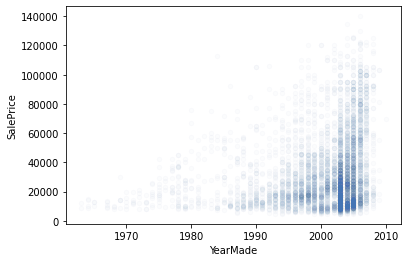

In [10]:
# now YearMade vs Price looks more reasonable
df_small = df.sample(n=5_000) # don't draw too many dots
df_small.plot.scatter('YearMade','SalePrice', alpha=0.02, c=color_palette['blue']);

In [11]:
# at this point all features are numeric, except for saledate, and missing values have been fixed.
df[df.columns[-3:]].head(5)

,Undercarriage_Pad_Width_na,YearMade_na,MachineHoursCurrentMeter_na
289125,True,False,True
289126,True,False,True
289127,True,False,True
289128,False,False,True
289129,True,False,True


### 5. Training a model with all features

Now that we have the dataframe prepped as pure numbers, we can use all the features to train a model and compare its performance to the baseline. The one exception is that **saledate** is still a timestamp (we will deal with that later).


In [12]:
X, y = df.drop(['SalePrice','saledate'], axis=1), df['SalePrice']
rf, oob_all = train_rf(X, y)

OOB R^2 0.89953 using 5,154,054 tree nodes with 43.0 median tree height


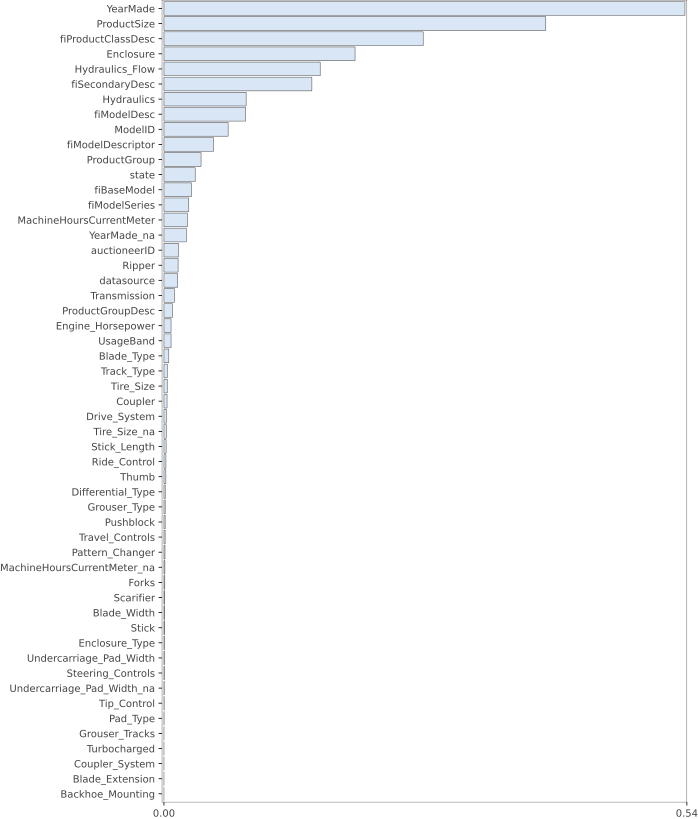

In [13]:
importances_ = importances(rf, X, y)
plot_importances(importances_, width=10, minheight=5)

In [15]:
df = df.reset_index(drop=True)
df.to_feather("../data/bulldozer-train-clean.feather")

That 0.899 is a big improvement upon our baseline score of 0.845, but we can do better through feature engineering. 

**YearMade** is still very important, but there's nothing left to do on that feature. Given their importance, we should take a close look at **ProductSize**, **fiProductClassDesc**, **Enclosure**, **Hydraulics_Flow**, **fiSecondaryDesc**, and so on. Also notice the long tail of unimportant features. These features could be truly unimportant or could be extremely important, but for a small subset of the records. The best strategy is to leave all features in the model until the end, and then gradually remove them until accuracy drops.